<a href="https://colab.research.google.com/github/liatico/Siamese-network/blob/main/deep_learning_assingment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1)	in this section we will use character level processing to try and predict search relevance.

1. Preprocess the training and testing data to contain sequences of single characters.
Note that you should do the above for both the search phrase and the item description
2.   Construct and train a Siamese network as described in the above liked paper.  The input to the network should be the character sequences constructing the search phrase and the item description, and the output should be the predicted search relevance score
3. As in previous tasks we would like to create either a naïve or model-based benchmark – use count vectorizer on the character sequences you generated on (a) along with any modeling or statistical method to create such a benchmark score – remember, only by comparing your results with a strong benchmark will truly serve your will to asses how good your model is
4. Use the model you have got, either last layer or any other layer as a feature extractor for other ML model (please select at least two of: xgboost, lightgbm, catboost, random forest, knn, svm) 


In [1]:
import pandas as pd
import numpy as np
import gensim 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import timeit
import matplotlib.pyplot as plt
import math
from torch import linalg as LA
import torch
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier
! pip install catboost
from catboost import CatBoostRegressor
from math import *

     |████████████████████████████████| 65.8MB 42kB/s 


Preprocess the training and testing data to contain sequences of single characters. Note that you should do the above for both the search phrase and the item description

In [2]:
train_path = "/content/drive/MyDrive/DL-ass3/train.csv"
test_path = "/content/drive/MyDrive/DL-ass3/test.csv"

y_test_path = "/content/drive/MyDrive/DL-ass3/solution.csv"

all_words = []
queries = []
products = []
targets = []

queries_test = []
products_test = []
targets_test = []
class Train_Corpus(object):
    def __iter__(self):
        for line in pd.read_csv(train_path, encoding="cp437").iterrows():
            # assume there's one document per line, tokens separated by whitespace
            yield str(line[1][3]).lower() ,str(line[1][2]).lower(), line[1][4]

class Test_Corpus(object):
    def __iter__(self):
        for line in pd.read_csv(test_path, encoding="cp437").iterrows():
            # assume there's one document per line, tokens separated by whitespace
            yield str(line[1][3]).lower() ,str(line[1][2]).lower()

class Y_Test_Corpus(object):
    def __iter__(self):
        for line in pd.read_csv(y_test_path, encoding="cp437").iterrows():
            # assume there's one document per line, tokens separated by whitespace
            yield line[1][1]
            
y_test_corpus = Y_Test_Corpus()
for y in y_test_corpus:
  targets_test.append(y)

corpus_memory_friendly = Train_Corpus()
for x1, x2, y in corpus_memory_friendly:  # load one vector into memory at a time
  queries.append(x1)
  products.append(x2)
  targets.append(y)
  all_words.append(x1)
  all_words.append(x2)

test_corpus = Test_Corpus()
for x1, x2 in test_corpus:
  queries_test.append(x1)
  products_test.append(x2)
  all_words.append(x1)
  all_words.append(x2)


# all_words = set(all_words)
all_words = ''.join(all_words)
len(queries_test), len(products_test), len(targets_test)

(166693, 166693, 166693)

In [3]:
len(queries), len(products), len(targets)

(74067, 74067, 74067)

In [4]:
set(targets)

{1.0, 1.25, 1.33, 1.5, 1.67, 1.75, 2.0, 2.25, 2.33, 2.5, 2.67, 2.75, 3.0}

In [5]:
def prerocess(raw_text):
  chars = sorted(list(set(raw_text)))
  char_to_int = dict((c, i) for i, c in enumerate(chars))
  int_to_char = dict((i, c) for i, c in enumerate(chars))
  # summarize the loaded data
  n_chars = len(raw_text)
  n_vocab = len(chars)
  print ("Total Characters: ", n_chars)
  print ("Total Vocab: ", n_vocab)
  return char_to_int, int_to_char, n_vocab

char_to_int, int_to_char, n_vocab =  prerocess(all_words)

Total Characters:  20967249
Total Vocab:  90


In [6]:
# prepre test set
test_queries_X = []
test_products_X = []
test__Y = []
test_queries_X_naiv = []
test_products_X_naiv = []

for i in range(len(queries_test)):
  raw_query = queries_test[i].lower()
  raw_product = products_test[i].lower()
  raw_product = np.array([char_to_int[char] for char in raw_product])
  raw_query = np.array([char_to_int[char] for char in raw_query])
  test_queries_X_naiv.append(raw_query)
  test_products_X_naiv.append(raw_product)
  # one-hot encode sequences
  query_array = [0]*n_vocab
  product_array = [0]*n_vocab
  for j in range(n_vocab):
    if j in raw_query:
      query_array[j] = 1
    else:
      query_array[j] = 0

  for j in range(n_vocab):
    if j in raw_product:
      product_array[j] = 1
    else:
      product_array[j] = 0

  test__Y.append(targets_test[i])
  test_queries_X.append(query_array)
  test_products_X.append(product_array)

len(test_queries_X), len(test_products_X), len(test__Y)

(166693, 166693, 166693)

In [7]:

# enc = OneHotEncoder(handle_unknown='ignore')
# array = np.array(list(char_to_int.items()))
# enc.fit(array)

# q_length = 13
queries_X = []
products_X = []
_Y = []
queries_X_naiv = []
products_X_naiv = []

for i in range(len(queries)):
  raw_query = queries[i]
  raw_product = products[i]
  raw_product = np.array([char_to_int[char] for char in raw_product])
  raw_query = np.array([char_to_int[char] for char in raw_query])
  queries_X_naiv.append(raw_query)
  products_X_naiv.append(raw_product)
  # one-hot encode sequences
  query_array = [0]*n_vocab
  product_array = [0]*n_vocab
  for j in range(n_vocab):
    if j in raw_query:
      query_array[j] = 1
    else:
      query_array[j] = 0

  for j in range(n_vocab):
    if j in raw_product:
      product_array[j] = 1
    else:
      product_array[j] = 0

  _Y.append(targets[i])
  queries_X.append(query_array)
  products_X.append(product_array)


n_patterns_queries = len(queries_X)
n_patterns_products = len(products_X)

len(_Y), len(queries_X), len(products_X)


(74067, 74067, 74067)

In [8]:
np.array(queries_X)

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [9]:
_Y = np.array(_Y)
X_queries = np.array(queries_X)
X_queries = np.reshape(X_queries, (n_patterns_queries, n_vocab, 1))
X_products = np.array(products_X)
X_products = np.reshape(X_products, (n_patterns_products, n_vocab, 1))


In [10]:
test__Y = np.array(test__Y)
test_X_queries = np.array(test_queries_X)
test_X_queries = np.reshape(test_X_queries, (len(test_queries_X), n_vocab, 1))
test_X_products = np.array(test_products_X)
test_X_products = np.reshape(test_X_products, (len(test_X_products), n_vocab, 1))


In [11]:
X_queries.shape, X_products.shape, _Y.shape


((74067, 90, 1), (74067, 90, 1), (74067,))

Construct and train a Siamese network as described in the above linked paper
(Arpita Das, Harish Yenala, Manoj Chinnakotla, Manish Shrivastava, Together we stand: Siamese Networks for Similar Question Retrieval, 2016). The input to the network should be the character sequences constructing the search phrase and the item description, and the output should be the predicted search relevance score
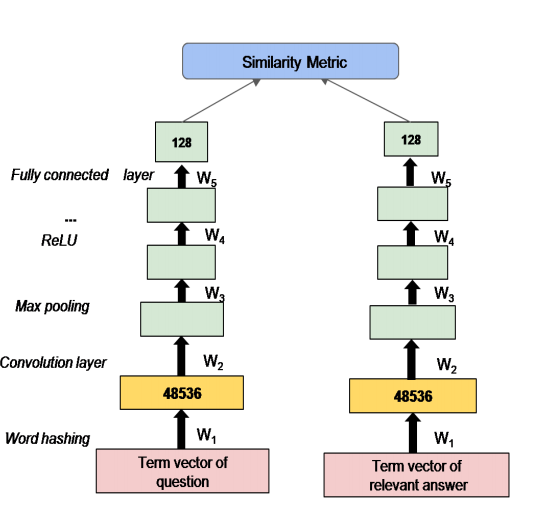

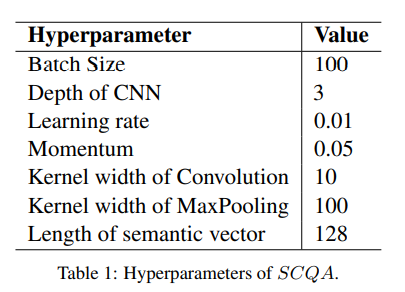

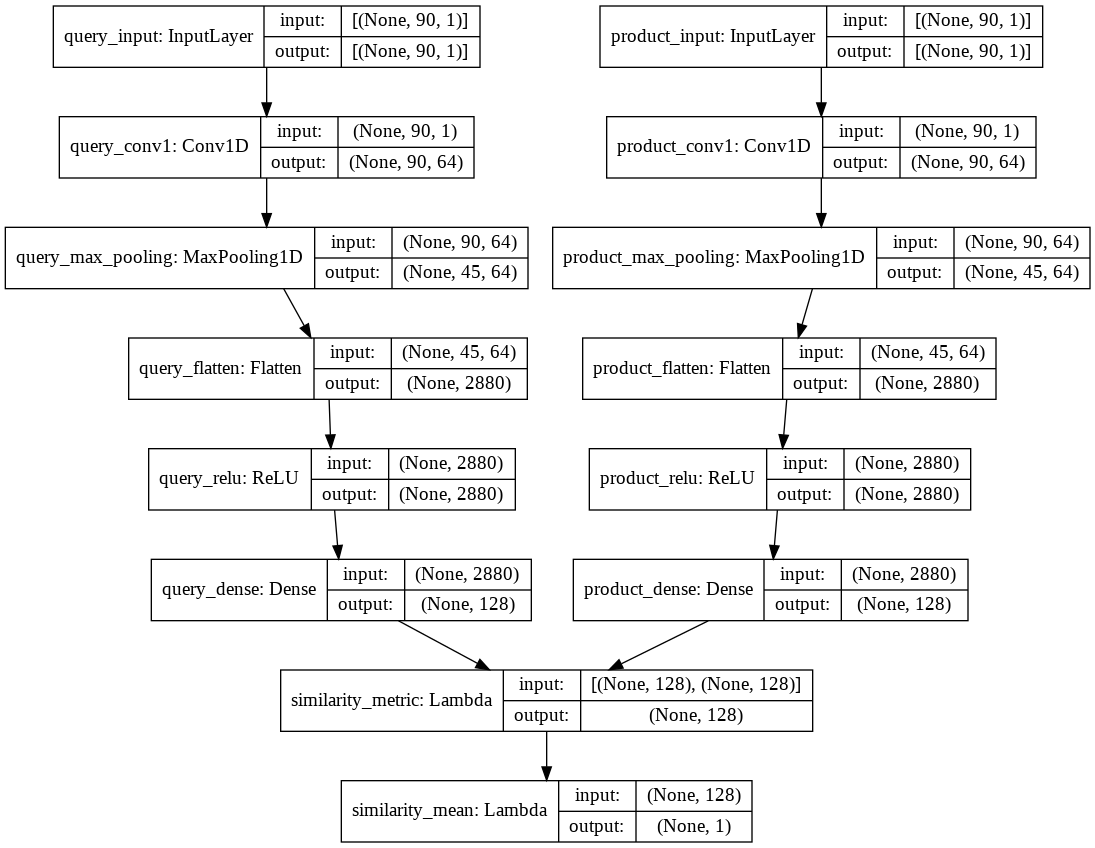

In [12]:
def create_model():
  W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
  b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

  query_inp = Input(shape=(n_vocab, 1), name='query_input')
  query = Conv1D(64, 10,activation='relu', padding = 'same', kernel_initializer=W_init, bias_initializer=b_init, name='query_conv1')(query_inp)
  query = MaxPooling1D(name='query_max_pooling')(query)
  query = Flatten(name='query_flatten')(query)
  query = ReLU(name='query_relu')(query)
  query = Dense(128, name='query_dense')(query)

  product_inp = Input(shape=(n_vocab, 1), name='product_input')
  product = Conv1D(64, 10, activation='relu',padding = 'same', kernel_initializer=W_init, bias_initializer=b_init, name='product_conv1')(product_inp)
  product = MaxPooling1D(name='product_max_pooling')(product)
  product = Flatten(name='product_flatten')(product)
  product = ReLU(name='product_relu')(product)
  product = Dense(128, name='product_dense')(product)

  L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), name='similarity_metric')([query, product])
  output = Lambda(lambda tensors: tf.reduce_mean(tensors,axis=1, keepdims=True), name='similarity_mean')(L1_layer)
    
  model = Model(inputs=[query_inp, product_inp], outputs=output)
  model.compile(optimizer=Adam(0.01), loss='mse', metrics=['mae', 'mse'])

  return model
model = create_model()
plot_model(model, show_shapes=True, show_layer_names=True)

In [13]:
filename = '/content/drive/MyDrive/DL-ass3/training_1/cp.ckpt'
cp_callback = ModelCheckpoint(filepath=filename,save_weights_only=True, verbose=1)
# print(set(np.argmax(_Y[:36000000], axis=1)))
start = timeit.default_timer()
history = model.fit(x=(X_queries[:70000], X_products[:70000]), y=_Y[:70000], epochs=20, batch_size=100, validation_data=((X_queries[70000:], X_products[70000:]), _Y[70000:]),callbacks=[cp_callback])
stop = timeit.default_timer()
print("fit run time: {:.3f} s".format(stop - start))


Epoch 1/20
700/700 [==============================] - 10s 4ms/step - loss: 17.0480 - mae: 1.6134 - mse: 17.0480 - val_loss: 0.2946 - val_mae: 0.4296 - val_mse: 0.2946

Epoch 00001: saving model to /content/drive/MyDrive/DL-ass3/training_1/cp.ckpt
Epoch 2/20
700/700 [==============================] - 2s 3ms/step - loss: 0.2869 - mae: 0.4401 - mse: 0.2869 - val_loss: 0.3035 - val_mae: 0.4378 - val_mse: 0.3035

Epoch 00002: saving model to /content/drive/MyDrive/DL-ass3/training_1/cp.ckpt
Epoch 3/20
700/700 [==============================] - 2s 3ms/step - loss: 0.2996 - mae: 0.4490 - mse: 0.2996 - val_loss: 0.3429 - val_mae: 0.4669 - val_mse: 0.3429

Epoch 00003: saving model to /content/drive/MyDrive/DL-ass3/training_1/cp.ckpt
Epoch 4/20
700/700 [==============================] - 2s 3ms/step - loss: 0.2983 - mae: 0.4456 - mse: 0.2983 - val_loss: 0.7006 - val_mae: 0.6747 - val_mse: 0.7006

Epoch 00004: saving model to /content/drive/MyDrive/DL-ass3/training_1/cp.ckpt
Epoch 5/20
700/700 [=

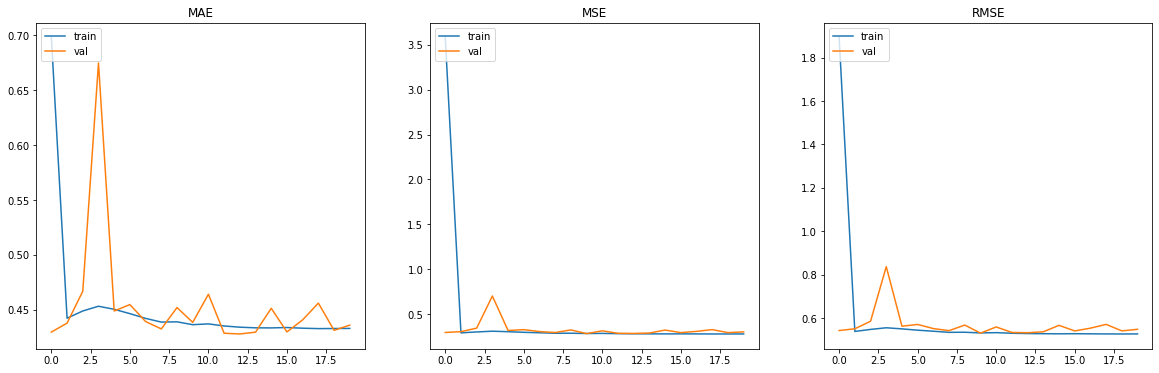

train mean RMSE: 0.6028205410030991
train mean MSE: 0.4510261923074722
train mean MAE: 0.45170852094888686


In [14]:

fig, ax = plt.subplots(1, 3, figsize=(20,6))
ax[0].plot(history.history['mae'], label="train")
ax[0].plot(history.history['val_mae'], label="val")
ax[0].set_title('MAE')
ax[0].legend(loc="upper left")
ax[1].plot(history.history['mse'], label="train")
ax[1].plot(history.history['val_mse'], label="val")
ax[1].set_title('MSE')
ax[1].legend(loc="upper left")
ax[2].plot(np.sqrt(history.history['mse']), label="train")
ax[2].plot(np.sqrt(history.history['val_mse']), label="val")
ax[2].set_title('RMSE')
ax[2].legend(loc="upper left")
plt.show()
# history.history['mae']
print("train mean RMSE: " + str(np.mean(np.sqrt(history.history['mse']))))
print("train mean MSE: " + str(np.mean(history.history['mse'])))
print("train mean MAE: " + str(np.mean(history.history['mae'])))

In [15]:
filename = '/content/drive/MyDrive/DL-ass3/training_1/cp.ckpt'
load_weights_model = create_model()
load_weights_model.load_weights(filename)

start = timeit.default_timer()
preds = load_weights_model.predict(x=(X_queries[70000:], X_products[70000:]))
stop = timeit.default_timer()
preds = np.mean(preds, axis=1)
print("predict run time: {:.3f} s".format(stop - start))

predict run time: 0.272 s


In [16]:
y_true = _Y[70000:]
rmse = math.sqrt(mean_squared_error(y_true, preds,squared=False))
mse = mean_squared_error(y_true, preds, squared=False)
mae = mean_absolute_error(y_true, preds)
print("Validation:\nRMSE: {:.3f}\nMSE: {:.3f}\nMAE: {:.3f}".format(rmse,mse, mae))

Validation:
RMSE: 0.741
MSE: 0.548
MAE: 0.436


In [17]:
start = timeit.default_timer()
preds = load_weights_model.predict(x=(test_X_queries, test_X_products))
stop = timeit.default_timer()
preds = np.mean(preds, axis=1)
print("predict run time: {:.3f} s".format(stop - start))

predict run time: 5.460 s


In [18]:
rmse = math.sqrt(mean_squared_error(test__Y, preds,squared=False))
mse = mean_squared_error(test__Y, preds, squared=False)
mae = mean_absolute_error(test__Y, preds)
print("Test:\nRMSE: {:.3f}\nMSE: {:.3f}\nMAE: {:.3f}".format(rmse,mse, mae))

Test:
RMSE: 1.410
MSE: 1.988
MAE: 1.404


As in previous tasks we would like to create either a naïve or model-based benchmark – use count vectorizer on the character sequences you generated on (a) along with any modeling or statistical method to create such a benchmark score – remember, only by comparing your results with a strong benchmark will truly serve your will to asses how good your model is

In [19]:

def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

In [20]:
# implement jaccard similarity score
similaritis = []
y_true = normalize(_Y[:70000,np.newaxis], axis=0)
start = timeit.default_timer()
for i in range(70000):
  similaritis.append(jaccard_similarity(queries_X_naiv[i],products_X_naiv[i]))

stop = timeit.default_timer()
print("train jaccard run time: {:.3f} s".format(stop - start))

rmse = math.sqrt(mean_squared_error(y_true, similaritis,squared=False))
mse = mean_squared_error(y_true, similaritis, squared=False)
mae = mean_absolute_error(y_true, similaritis)
print("Jaccard similarity train:\nRMSE: {:.3f}\nMSE: {:.3f}\nMAE: {:.3f}".format(rmse,mse, mae))



train jaccard run time: 1.938 s
Jaccard similarity train:
RMSE: 0.696
MSE: 0.485
MAE: 0.466


In [21]:
similaritis = []
y_true = normalize(_Y[70000:,np.newaxis], axis=0)
start = timeit.default_timer()
for i in range(len(queries_X_naiv[70000:])):
  similaritis.append(jaccard_similarity(queries_X_naiv[i],products_X_naiv[i]))

stop = timeit.default_timer()
print("val jaccard run time: {:.3f} s".format(stop - start))

rmse = math.sqrt(mean_squared_error(y_true, similaritis,squared=False))
mse = mean_squared_error(y_true, similaritis, squared=False)
mae = mean_absolute_error(y_true, similaritis)
print("Jaccard similarity val:\nRMSE: {:.3f}\nMSE: {:.3f}\nMAE: {:.3f}".format(rmse,mse, mae))

val jaccard run time: 0.111 s
Jaccard similarity val:
RMSE: 0.664
MSE: 0.441
MAE: 0.420


In [22]:
similaritis = []
y_true = normalize(test__Y[:,np.newaxis], axis=0)
start = timeit.default_timer()
for i in range(len(test_queries_X_naiv)):
  similaritis.append(jaccard_similarity(test_queries_X_naiv[i],test_products_X_naiv[i]))

stop = timeit.default_timer()
print("Test jaccard run time: {:.3f} s".format(stop - start))

rmse = math.sqrt(mean_squared_error(y_true, similaritis,squared=False))
mse = mean_squared_error(y_true, similaritis, squared=False)
mae = mean_absolute_error(y_true, similaritis)
print("Jaccard similarity Test:\nRMSE: {:.3f}\nMSE: {:.3f}\nMAE: {:.3f}".format(rmse,mse, mae))

Test jaccard run time: 4.508 s
Jaccard similarity Test:
RMSE: 0.690
MSE: 0.477
MAE: 0.457


Use the model you have got, either last layer or any other layer as a feature extractor for other ML model (please select at least two of: xgboost, lightgbm, catboost, random forest, knn, svm) 

In [26]:
# feature extractor:
extractor = model.get_layer('similarity_metric').output
extractor.trainable=False
extractor_model = Model(inputs=[model.get_layer('query_input').input, model.get_layer('product_input').input], outputs=extractor)
extractor_model.compile(optimizer=Adam(0.01), loss='mse', metrics=['mae', 'mse'])
plot_model(extractor_model, show_shapes=True, show_layer_names=True)

train_features = extractor_model.predict(x=(X_queries[:70000], X_products[:70000]))
val_featurs = extractor_model.predict(x=(X_queries[70000:], X_products[70000:]))
train_labels = normalize(_Y[:70000,np.newaxis], axis=0).ravel()
val_labels = normalize(_Y[70000:,np.newaxis], axis=0).ravel()
test_features = extractor_model.predict(x=(test_X_queries,test_X_products))
test_labels = normalize(test__Y[:,np.newaxis], axis=0).ravel()


In [27]:

# xgboost model
start = timeit.default_timer()
xg_model = XGBClassifier()
progress = xg_model.fit(train_features, train_labels, eval_metric=["rmse","mae"])
y_pred = xg_model.predict(val_featurs)

stop = timeit.default_timer()
print("xgboost run time: {:.3f} s".format(stop - start))

rmse = math.sqrt(mean_squared_error(val_labels, y_pred,squared=False))
mse = mean_squared_error(val_labels, y_pred, squared=False)
mae = mean_absolute_error(val_labels, y_pred)
print("feature extraction with xg-boost Validation:\nRMSE: {:.3f}\nMSE: {:.3f}\nMAE: {:.3f}".format(rmse,mse, mae))


xgboost run time: 438.559 s
feature extraction with xg-boost Validation:
RMSE: 0.108
MSE: 0.012
MAE: 0.011


In [28]:
train_preds = xg_model.predict(train_features)
rmse = math.sqrt(mean_squared_error(train_labels, train_preds,squared=False))
mse = mean_squared_error(train_labels, train_preds, squared=False)
mae = mean_absolute_error(train_labels, train_preds)
print("feature extraction with xg-boost Train:\nRMSE: {:.3f}\nMSE: {:.3f}\nMAE: {:.3f}".format(rmse,mse, mae))

feature extraction with xg-boost Train:
RMSE: 0.033
MSE: 0.001
MAE: 0.001


In [29]:
test_preds = xg_model.predict(test_features)
rmse = math.sqrt(mean_squared_error(test_labels, test_preds,squared=False))
mse = mean_squared_error(test_labels, test_preds, squared=False)
mae = mean_absolute_error(test_labels, test_preds)
print("feature extraction with xg-boost Test:\nRMSE: {:.3f}\nMSE: {:.3f}\nMAE: {:.3f}".format(rmse,mse, mae))

feature extraction with xg-boost Test:
RMSE: 0.059
MSE: 0.003
MAE: 0.003


In [30]:

# catboost model
start = timeit.default_timer()
cat_model = CatBoostRegressor(iterations=1000, task_type="GPU",devices='0:1')
cat_progress = cat_model.fit(train_features, train_labels,verbose=0,plot=True)
y_pred = cat_model.predict(val_featurs)
stop = timeit.default_timer()
print("catboost run time: {:.3f} s".format(stop - start))

rmse = math.sqrt(mean_squared_error(val_labels, y_pred,squared=False))
mse = mean_squared_error(val_labels, y_pred, squared=False)
mae = mean_absolute_error(val_labels, y_pred)
print("feature extraction with cat-boost Validation:\nRMSE: {:.3f}\nMSE: {:.3f}\nMAE: {:.3f}".format(rmse,mse, mae))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

catboost run time: 6.487 s
feature extraction with cat-boost Validation:
RMSE: 0.110
MSE: 0.012
MAE: 0.012


In [31]:
train_preds = cat_model.predict(train_features)
rmse = math.sqrt(mean_squared_error(train_labels, train_preds,squared=False))
mse = mean_squared_error(train_labels, train_preds, squared=False)
mae = mean_absolute_error(train_labels, train_preds)
print("feature extraction with cat-boost Train:\nRMSE: {:.3f}\nMSE: {:.3f}\nMAE: {:.3f}".format(rmse,mse, mae))

feature extraction with cat-boost Train:
RMSE: 0.028
MSE: 0.001
MAE: 0.001


In [32]:
test_preds = cat_model.predict(test_features)
rmse = math.sqrt(mean_squared_error(test_labels, test_preds,squared=False))
mse = mean_squared_error(test_labels, test_preds, squared=False)
mae = mean_absolute_error(test_labels, test_preds)
print("feature extraction with cat-boost Test:\nRMSE: {:.3f}\nMSE: {:.3f}\nMAE: {:.3f}".format(rmse,mse, mae))

feature extraction with cat-boost Test:
RMSE: 0.054
MSE: 0.003
MAE: 0.002
